In [94]:
# import sys
# !{sys.executable} -m pip install --upgrade pip
# !{sys.executable} -m pip install nltk
# !{sys.executable} -m pip install -U spacy
# !{sys.executable} -m pip install gensim
# !{sys.executable} -m spacy download en_core_web_sm
# !{sys.executable} -m pip install pyLDAvis
# !{sys.executable} -m pip install matplotlib
# !{sys.executable} -m pip install langdetect
# !{sys.executable} -m pip install seaborn
# !{sys.executable} -m pip install yellowbrick
# !{sys.executable} -m pip install langdetect
# !{sys.executable} -m pip install dill

# !{sys.executable} -m pip install wordcloud

In [99]:
# Run in python console
import re
import os
import numpy as np
import pandas as pd
import random
import dill

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy
import en_core_web_sm

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# NLTK Stop words
import nltk; nltk.download('stopwords')
import spacy
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

from langdetect import detect

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns

from yellowbrick.features import FeatureImportances
from yellowbrick.regressor import PredictionError, ResidualsPlot
from yellowbrick.model_selection import CVScores

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import BayesianRidge, LinearRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score


from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Understanding how listing description influence price and listing rating

The AirBnb dataset provides with features not only that have numeric or structured values but also unstructured data. To mention a few examples: the name of of the property, a short description of the space, an overview of the neighborhood and a description of the listing itself. As part of our project we would like to use Natural Language Processing techniques to understand how unstructured data available for each listing might influence price.

The reason we believe that there might be a relationship betweeen the listing description and the price is because 
we think that what makes a listing valuable is not only their features per se but also the way the place is presented to the potential guest. This, not only includes the pictures of the listing but also the words that the listing owners pick to describe their listing and assumingly seeks to attrack their potential customers. We assume that by including certain words in the description could potentially increase the attractiveness of a certain property to be rented. Thus, due to supply and demand law, can assume that the more demanded a property is, the higher the value it could have. 

To begin with the analysis we want to see if there are similarities in the way listing owners describe their place and the price they charge per night. We proceed with the assumption that listings with similar features will use similar words to describe their property. Furthermore we are curious about how words in the description could inform us about the listing's overall rating.

For this reason we will be using this notebook to try to answer the following questions:

1. Do listings using similar words in their description share a similar price?
2. Do listings using similar words in their description share other features that are relevant to predict price?
3. Do listings using similar words in their description end up having similar guest acceptance/rating?

For this purpose we will first, use Latent Dirichlet Allocation to elicit the latent topics in the description. Latent Dirichlet Allocation is an unsupervised algorithm, largely used in Natural Language Processing to perform what is known as Topic Modeling. This algorightm uses probability distribution to discover which parts of the data are similar. In the context of our project we would try to discover the similar words used the description of New York City listings that could potentially influence price.

## Importing data into DataFrame

In [3]:
path = '../data/new-york-city-airbnb-open-data/'
listings_csv = os.path.join(path,'listings.csv')

listings_df =  pd.read_csv(listings_csv,low_memory=False)

In [4]:
# Creating content column with name and description of property
listings_df['content'] = listings_df['name'] + listings_df['description']
content = listings_df[['id','content']]

As we will be able to see, the description is the single text field with fewer than 3% missing values. This is also one of the reasons why we chose to work with this field to experiment with NLP into trying to predict price.

In [5]:
summary_nulls = round((listings_df.summary.isnull().sum()/listings_df.shape[0])*100, 1)
space = round((listings_df.space.isnull().sum()/listings_df.shape[0])*100, 1)
description = round((listings_df.description.isnull().sum()/listings_df.shape[0])*100, 1)
neighborhood_overview = round((listings_df.neighborhood_overview.isnull().sum()/listings_df.shape[0])*100, 1)
notes = round((listings_df.notes.isnull().sum()/listings_df.shape[0])*100, 1)
transit = round((listings_df.transit.isnull().sum()/listings_df.shape[0])*100, 1)
access = round((listings_df.access.isnull().sum()/listings_df.shape[0])*100, 1)
interaction = round((listings_df.interaction.isnull().sum()/listings_df.shape[0])*100, 1)
house_rules = round((listings_df.house_rules.isnull().sum()/listings_df.shape[0])*100, 1)
name = round((listings_df.name.isnull().sum()/listings_df.shape[0])*100, 1)

In [6]:
print(f"{summary_nulls}% of listings have empty summaries")
print(f"{space}% of listings have empty space description")
print(f"{description}% of listings have empty description")
print(f"{neighborhood_overview}% of listings have empty overviews on their neighborhood")
print(f"{notes}% of listings have no notes from the host")
print(f"{transit}% of listings have no information on transit")
print(f"{access}% of listings have no information on accessibility")
print(f"{interaction}% of listings have no information on interaction")
print(f"{house_rules}% of listings have no information on house_rules")
print(f"{name}% of listings have no information on name")

4.8% of listings have empty summaries
28.0% of listings have empty space description
2.4% of listings have empty description
34.4% of listings have empty overviews on their neighborhood
59.6% of listings have no notes from the host
34.4% of listings have no information on transit
47.2% of listings have no information on accessibility
40.2% of listings have no information on interaction
39.1% of listings have no information on house_rules
0.0% of listings have no information on name


Importing numeric features from previous Exploratory Data Analysis and Modeling

In [7]:
# Importing model df
model_cols_df = pd.read_csv('../data/new-york-city-airbnb-open-data/model_columns_listings.csv',index_col = 0)

In [8]:
model_cols_df.iloc[:,0:4].head()

,id,host_since,host_is_superhost,host_identity_verified
0,2595,733294,0,1
1,3831,733383,0,1
2,5099,733440,0,0
3,5121,733441,0,0
4,5178,733469,0,0


In [9]:
# Joining the new created 'content' column with the model dataframe just to choose rows that are relevant
df_model = pd.merge(left=model_cols_df, right=content, how='left', on='id')

# dropping null values
df_model = df_model.dropna()

In [10]:
df_model.iloc[:,0:4].head()

,id,host_since,host_is_superhost,host_identity_verified
0,2595,733294,0,1
1,3831,733383,0,1
2,5099,733440,0,0
3,5121,733441,0,0
4,5178,733469,0,0


## Predicting Language from content

As we may already know, AirBnb is a platform used by people from all around the world. Therefore, some hosts that want to attract guests who speak languages other than English might want to use different language or languages to describe their place. For our analysis we want to make sure that we are working with a single language and since the majority of reviews are written in English, we will use langdetect, to determine those descriptions written in English only. Langdetect is a language detection algorithm that supports 55 languages out of the box. To maximize the probability of the algorithms predicting the correct language we make sure we send it a long enough string.

In [11]:
def predict_lang(x):
    lang=''
    txt_len=len(x)
    if txt_len>50:
        try:
            lang=detect(x)
        except Exception as e:
            lang=''
    return lang

In [12]:
df_model['content_lang'] = df_model.content.apply(lambda x: predict_lang(x))

In [13]:
# getting only text in English
df_model_en_desc = df_model[df_model.content_lang=='en']

In [14]:
df_model.shape, df_model_en_desc.shape

((27354, 47), (27106, 47))

In [15]:
df_model_en_desc.iloc[:,0:4].head()

,id,host_since,host_is_superhost,host_identity_verified
0,2595,733294,0,1
1,3831,733383,0,1
2,5099,733440,0,0
3,5121,733441,0,0
4,5178,733469,0,0


## LDA for Topic Modeling in Listing Description

In [16]:
def generate_list_content(df):
#     df['content'] = df['name'] + df['summary']
#     df['content'] = df['content'].replace(np.nan, '', regex=True)
    
    # Convert to list
    data = df['content'].values.tolist()

    # Remove Emails
    data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

    # Remove new line characters
    data = [re.sub('\s+', ' ', sent) for sent in data]

    # Remove distracting single quotes
    data = [re.sub("\'", "", sent) for sent in data]
    
    
    return data

In [17]:
lst_texts = generate_list_content(df_model_en_desc)

In [18]:
len(lst_texts)

27106

## Tokenize words and clean up text

In [19]:
# here we are tokenizing each document.
def content_to_words(lst_texts):
    for text in lst_texts:
        yield(gensim.utils.simple_preprocess(str(text), deacc=True))
        
# data_words is a list where each element is the tokenized document
tokenized_content = list(content_to_words(lst_texts))

## Create bigram and trigrams

In [20]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(tokenized_content, min_count=10, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[tokenized_content], threshold=100)  


# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

## Remove Stopwords, Make Bigrams and Lemmatize

In [21]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(tokenized_content):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in tokenized_content]

def make_bigrams(tokenized_content):
    return [bigram_mod[doc] for doc in tokenized_content]

def make_trigrams(tokenized_content):
    return [trigram_mod[bigram_mod[doc]] for doc in tokenized_content]

def lemmatization(tokenized_content, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in tokenized_content:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out
nlp = en_core_web_sm.load(disable=['parser', 'ner'])

In [22]:
# Remove Stop Words
tokenized_content_nostops = remove_stopwords(tokenized_content)

# Form Bigrams
tokenized_content_bigrams = make_bigrams(tokenized_content_nostops)

# Do lemmatization keeping only noun, adj, vb, adv
tokenized_content_lemmatized = lemmatization(tokenized_content_bigrams, 
                                             allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

## Create the Dictionary and Corpus needed for Topic Modeling

In [23]:
# Create Dictionary:
# Mapping from word IDs to words. 
# It is used to determine the vocabulary size, as well as for debugging and topic printing.
id2word = corpora.Dictionary(tokenized_content_lemmatized)
# print(len(id2word)) # corpus has 14118 unique tokens

# Term Document Frequency
# Convert document (a list of words) into the bag-of-words format = list of (token_id, token_count) 2-tuples.
# Word with their corresponding id
corpus = [id2word.doc2bow(text) for text in tokenized_content_lemmatized]

# View
# print(corpus[:1])

The biggest challenge of using LDA for Topic Modeling is determining the right amount of topics *n*. Therefore we will use two metrics: Perplexity and Coherence as well as the pyLDAvis to approximately determine the right number of topics that are latent in our corpus (description).

## Build list of topic models

In [24]:
def build_topics(num_topics):
    list_models=[]
    for n in num_topics:
        topic_name = 'lda_model_' + str(n)
        topic_name = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, 
                                                     num_topics=n, random_state=100, 
                                                     update_every=1, chunksize=100, 
                                                     passes=10, alpha='auto', 
                                                     per_word_topics=True)
        list_models.append(topic_name)
    return list_models

# num_topics = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
num_topics = [2,3,4,5,6,7,8,9,10]
models = build_topics(num_topics)

In [25]:
## Saving the models to disc
from gensim.test.utils import datapath

# Save model to disk.
for i in range(len(models)):
    temp_file = datapath("model" + str(i))
    models[i].save(temp_file)

In [26]:
# Load a potentially pretrained model from disk.
# lda = LdaModel.load(temp_file)

## Compute Model Perplexity and Coherence Score for all models

According to (Jansen, 2018) "Perplexity when applied to LDA meassures how well the topic-word probability distribution recovered by the model predicts a sample, for example, unseen text documents. It is based on the entropy H(p) of this distribution p and computed with respect to the set of tokens w. Measures closer to zero imply the distribution is better at predicting the sample".

In terms of Coherence, we will be using Gensim implementation based on the paper writen by (Roder, et al., 2015). Larger scores in coherence mean better topic representation of the corpus.

## Bibliography

Jansen, S. (2018). Perplexity. In Hands-on machine learning for algorithmic trading: Design and implement investment strategies based on smart algorithms that learn from data using Python. Birmingham: Packt Publishing.

Roder, M., Both, A., and Hinneburg, A. (2015). Exploring the Space of Topic Coherence Measures. In Proceedings of the Eighth ACM International Conference on Web Search and Data Mining, WSDM ’15, pages 399–408, New York, NY, USA. ACM.

In [27]:
def calc_perplexity_coherence(models):
    list_perplexity = []
    list_coherence = []
    
    for model in models:
        list_perplexity.append(model.log_perplexity(corpus))
        coherence_model_lda = CoherenceModel(model=model, texts=tokenized_content_lemmatized, 
                                             dictionary=id2word, coherence='c_v')
        list_coherence.append(coherence_model_lda.get_coherence())
    return list_perplexity, list_coherence

x = calc_perplexity_coherence(models)      

In [28]:
df_metrics = pd.DataFrame(list(x)).transpose()
df_metrics.columns = ['Perplexity','Coherence']
df_metrics['Number of topics'] = num_topics
df_metrics

,Perplexity,Coherence,Number of topics
0,-6.709800,0.434439,2
1,-6.697495,0.471912,3
2,-6.707511,0.482535,4
3,-6.722294,0.542381,5
4,-6.740221,0.457957,6
5,-6.765529,0.451070,7
6,-6.796905,0.395879,8
7,-6.847429,0.494829,9
8,-6.943411,0.432043,10


## Graphic of number of Topics and Perplexity

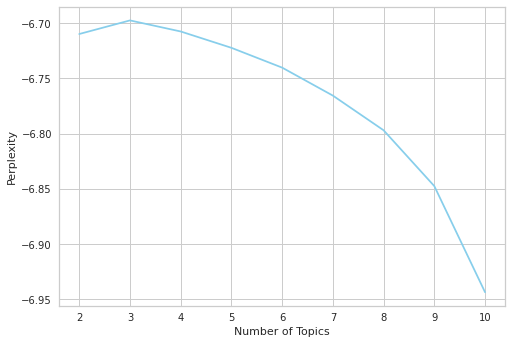

In [29]:
# Perplexity needs to be as low as possible 
plt.plot( 'Number of topics', 'Perplexity', data=df_metrics, color='skyblue')
plt.xlabel("Number of Topics")
plt.ylabel("Perplexity")
plt.show()

## Graphic of number of Topics and Coherence

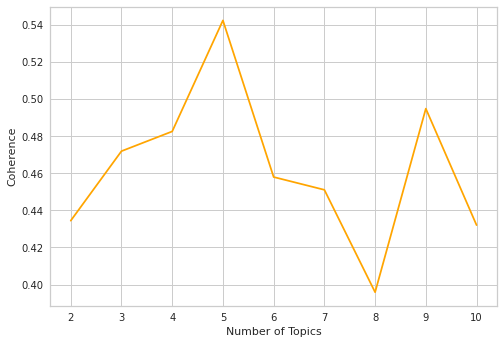

In [30]:
# Perplexity needs to be as low as possible 
plt.plot( 'Number of topics', 'Coherence', data=df_metrics, color='orange')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence")
plt.show()

## Visualizing topics according to the best *n*

### Visualization with 5 topics

In [31]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis_5 = pyLDAvis.gensim.prepare(models[3], corpus, id2word, sort_topics=False)
vis_5

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
0       1.986634        1       1  0.247758  0.281625
1      34.760082        1       2 -0.204653  0.050573
2      30.750340        1       3 -0.211790 -0.123464
3       2.052923        1       4  0.320758 -0.248115
4      30.450022        1       5 -0.152073  0.039381, topic_info=     Category          Freq          Term         Total  loglift  logprob
term                                                                     
289   Default  12477.000000          stay  12477.000000  30.0000  30.0000
99    Default  40461.000000          room  40461.000000  29.0000  29.0000
141   Default  19733.000000          walk  19733.000000  28.0000  28.0000
106   Default  19207.000000         train  19207.000000  27.0000  27.0000
93    Default  18489.000000        minute  18489.000000  26.0000  26.0000
8     Default  20622.000000           bed  20622.000000  25.0000  25.0000
185   Default  15852.000000         space  15852.000000  24.0000  24.0000
218   Default  16750.000000    restaurant  16750.000000  23.0000  23.0000
87    Default  16190.000000         guest  16190.000000  22.0000  22.0000
63    Default  29359.000000       bedroom  29359.000000  21.0000  21.0000
198   Default  14113.000000          away  14113.000000  20.0000  20.0000
20    Default  13218.000000          full  13218.000000  19.0000  19.0000
64    Default  11796.000000         block  11796.000000  18.0000  18.0000
201   Default   4026.000000         check   4026.000000  17.0000  17.0000
110   Default  44839.000000     apartment  44839.000000  16.0000  16.0000
137   Default  11257.000000        subway  11257.000000  15.0000  15.0000
239   Default   6720.000000         fully   6720.000000  14.0000  14.0000
202   Default  10320.000000         close  10320.000000  13.0000  13.0000
19    Default  11561.000000         floor  11561.000000  12.0000  12.0000
182   Default  10150.000000         share  10150.000000  11.0000  11.0000
236   Default   5205.000000         equip   5205.000000  10.0000  10.0000
309   Default  11936.000000          home  11936.000000   9.0000   9.0000
249   Default  12697.000000  neighborhood  12697.000000   8.0000   8.0000
228   Default   9524.000000           bar   9524.000000   7.0000   7.0000
366   Default   8704.000000         clean   8704.000000   6.0000   6.0000
55    Default   4925.000000         towel   4925.000000   5.0000   5.0000
136   Default   8150.000000       station   8150.000000   4.0000   4.0000
29    Default   8678.000000         large   8678.000000   3.0000   3.0000
500   Default   3176.000000          text   3176.000000   2.0000   2.0000
131   Default   8596.000000         queen   8596.000000   1.0000   1.0000
...       ...           ...           ...           ...      ...      ...
1176   Topic5   1165.250854          lock   1166.102173   1.1884  -6.1475
494    Topic5   1115.971802           let   1116.829468   1.1883  -6.1907
595    Topic5   5442.252930          make   5454.795410   1.1868  -4.6062
368    Topic5   3649.791992           day   3667.773193   1.1842  -5.0057
32     Topic5   2311.190186          love   2314.463135   1.1877  -5.4626
597    Topic5   1859.901978       privacy   1864.579468   1.1866  -5.6799
108    Topic5   5756.288086           use   5902.645020   1.1640  -4.5501
309    Topic5  11191.099609          home  11936.238281   1.1246  -3.8853
492    Topic5   4531.142090          free   4800.355957   1.1314  -4.7894
289    Topic5  10982.131836          stay  12477.845703   1.0614  -3.9041
94     Topic5   8862.173828          need  10092.677734   1.0591  -4.1186
99     Topic5  29691.468750          room  40461.523438   0.8796  -2.9095
130    Topic5   3401.714844        people   3740.552734   1.0941  -5.0761
139    Topic5   6447.590820          time   7908.259766   0.9849  -4.4367
175    Topic5   7579.582031         place   9872.511719   0.9248  -4.2749
548    Topic5   2134.799072

In [32]:
pyLDAvis.save_html(vis_5, '../data/visualization_5_topics.html')

### Visualization with 7 topics

In [33]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis_7 = pyLDAvis.gensim.prepare(models[5], corpus, id2word, sort_topics=False)
vis_7

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
0       1.103190        1       1 -0.261350 -0.129998
1      24.705181        1       2  0.235453 -0.025977
2      11.965197        1       3  0.135675 -0.127835
3       1.529288        1       4 -0.260959 -0.138733
4      27.231684        1       5  0.169462 -0.100548
5      30.711246        1       6  0.184701  0.197323
6       2.754218        1       7 -0.202982  0.325767, topic_info=     Category          Freq            Term         Total  loglift  logprob
term                                                                       
289   Default  12575.000000            stay  12575.000000  30.0000  30.0000
8     Default  19715.000000             bed  19715.000000  29.0000  29.0000
99    Default  40218.000000            room  40218.000000  28.0000  28.0000
110   Default  43386.000000       apartment  43386.000000  27.0000  27.0000
141   Default  20082.000000            walk  20082.000000  26.0000  26.0000
63    Default  28192.000000         bedroom  28192.000000  25.0000  25.0000
19    Default  12119.000000           floor  12119.000000  24.0000  24.0000
106   Default  19546.000000           train  19546.000000  23.0000  23.0000
93    Default  18815.000000          minute  18815.000000  22.0000  22.0000
114   Default   5981.000000             bus   5981.000000  21.0000  21.0000
87    Default  16182.000000           guest  16182.000000  20.0000  20.0000
218   Default  17046.000000      restaurant  17046.000000  19.0000  19.0000
20    Default  12636.000000            full  12636.000000  18.0000  18.0000
198   Default  14362.000000            away  14362.000000  17.0000  17.0000
96    Default  20235.000000         private  20235.000000  16.0000  16.0000
345   Default   4274.000000             min   4274.000000  15.0000  15.0000
201   Default   4097.000000           check   4097.000000  14.0000  14.0000
64    Default  12004.000000           block  12004.000000  13.0000  13.0000
249   Default  12894.000000    neighborhood  12894.000000  12.0000  12.0000
136   Default   8286.000000         station   8286.000000  11.0000  11.0000
137   Default  11455.000000          subway  11455.000000  10.0000  10.0000
309   Default  12533.000000            home  12533.000000   9.0000   9.0000
182   Default  10145.000000           share  10145.000000   8.0000   8.0000
202   Default  10502.000000           close  10502.000000   7.0000   7.0000
185   Default  16001.000000           space  16001.000000   6.0000   6.0000
28    Default  11605.000000         kitchen  11605.000000   5.0000   5.0000
228   Default   9692.000000             bar   9692.000000   4.0000   4.0000
131   Default   8214.000000           queen   8214.000000   3.0000   3.0000
840   Default   2990.000000         parking   2990.000000   2.0000   2.0000
134   Default   7705.000000            size   7705.000000   1.0000   1.0000
...       ...           ...             ...           ...      ...      ...
1664   Topic7    424.384552         stocked    425.320251   3.5898  -4.7546
470    Topic7    392.375824         premise    393.310181   3.5897  -4.8330
1826   Topic7    367.515778        brooklyn    368.452087   3.5895  -4.8984
1477   Topic7    354.667603           point    355.603149   3.5894  -4.9340
1171   Topic7    353.871887         cabinet    354.808136   3.5894  -4.9363
2732   Topic7    343.490143         college    344.424225   3.5893  -4.9660
801    Topic7    291.373047         cuisine    292.306458   3.5888  -5.1306
1777   Topic7    287.388641         various    288.321655   3.5888  -5.1444
6951   Topic7    287.112518             tra    288.050720   3.5888  -5.1453
2927   Topic7    264.283722          bakery    265.217896   3.5885  -5.2282
1924   Topic7    253.771591            mini    254.708420   3.5884  -5.2688
1828   Topic7    248.038696       equipment    248.975662   3.5883  -5.2916
1604   Topic7    236.062347             cab    236.

In [34]:
pyLDAvis.save_html(vis_7, '../data/visualization_7_topics.html')

### Visualization with 9 topics 

In [35]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis_9 = pyLDAvis.gensim.prepare(models[7], corpus, id2word, sort_topics=False)
vis_9

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
0       1.136838        1       1  0.269458  0.007551
1      20.664433        1       2 -0.179443  0.155474
2       8.510762        1       3 -0.026174  0.195771
3       1.183876        1       4  0.265341 -0.003663
4      25.438599        1       5 -0.142720  0.036487
5      11.165954        1       6 -0.130608  0.145224
6       3.249319        1       7  0.205709  0.010092
7      20.844503        1       8 -0.217323 -0.172536
8       7.805718        1       9 -0.044238 -0.374401, topic_info=     Category          Freq          Term         Total  loglift  logprob
term                                                                     
96    Default  22300.000000       private  22300.000000  30.0000  30.0000
106   Default  19027.000000         train  19027.000000  29.0000  29.0000
93    Default  18315.000000        minute  18315.000000  28.0000  28.0000
63    Default  29026.000000       bedroom  29026.000000  27.0000  27.0000
110   Default  44298.000000     apartment  44298.000000  26.0000  26.0000
99    Default  40929.000000          room  40929.000000  25.0000  25.0000
141   Default  19992.000000          walk  19992.000000  24.0000  24.0000
8     Default  19961.000000           bed  19961.000000  23.0000  23.0000
19    Default  12200.000000         floor  12200.000000  22.0000  22.0000
218   Default  17292.000000    restaurant  17292.000000  21.0000  21.0000
198   Default  14256.000000          away  14256.000000  20.0000  20.0000
87    Default  16214.000000         guest  16214.000000  19.0000  19.0000
136   Default   8074.000000       station   8074.000000  18.0000  18.0000
249   Default  13055.000000  neighborhood  13055.000000  17.0000  17.0000
20    Default  12794.000000          full  12794.000000  16.0000  16.0000
64    Default  12178.000000         block  12178.000000  15.0000  15.0000
117   Default   7157.000000        coffee   7157.000000  14.0000  14.0000
381   Default   5477.000000       provide   5477.000000  13.0000  13.0000
28    Default  11856.000000       kitchen  11856.000000  12.0000  12.0000
137   Default  11621.000000        subway  11621.000000  11.0000  11.0000
289   Default  12608.000000          stay  12608.000000  10.0000  10.0000
127   Default  10554.000000        living  10554.000000   9.0000   9.0000
201   Default   4104.000000         check   4104.000000   8.0000   8.0000
366   Default   8682.000000         clean   8682.000000   7.0000   7.0000
31    Default  14678.000000        locate  14678.000000   6.0000   6.0000
228   Default   9833.000000           bar   9833.000000   5.0000   5.0000
239   Default   6564.000000         fully   6564.000000   4.0000   4.0000
55    Default   4392.000000         towel   4392.000000   3.0000   3.0000
114   Default   5891.000000           bus   5891.000000   2.0000   2.0000
182   Default  10165.000000         share  10165.000000   1.0000   1.0000
...       ...           ...           ...           ...      ...      ...
833    Topic9    575.593384         ferry    576.562317   2.5486  -5.4915
832    Topic9    393.987823       feeling    394.957916   2.5479  -5.8706
2053   Topic9    387.701050    everywhere    388.670349   2.5478  -5.8867
470    Topic9    386.399048       premise    387.368317   2.5478  -5.8900
1837   Topic9    358.913055         staff    359.883606   2.5476  -5.9638
136    Topic9   8052.413086       station   8074.500000   2.5476  -2.8532
4236   Topic9    323.220520    university    324.191406   2.5473  -6.0686
812    Topic9    297.837585          type    298.806854   2.5471  -6.1504
2555   Topic9    288.393860    definitely    289.363281   2.5470  -6.1826
2578   Topic9    288.622528        pickup    289.595093   2.5469  -6.1818
801    Topic9    286.950806       cuisine    287.919830   2.5469  -6.1876
1385   Topic9    286.365326        change    287.334869   2.5469  -6.1896
4633   Topic9    269.179626     s

In [36]:
pyLDAvis.save_html(vis_9, '../data/visualization_9_topics.html')

## Creating DataFrame with scores and topics for 5 topics

In [37]:
# function that returns data frame with 
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=lst_texts):
    # Init output
    sent_topics_df = list()
#     df_model_en_desc.reset_index(inplace=True)
    
    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
#         print(row)
        sent_topics_df.append(row)
        
    sent_topics_df = pd.DataFrame(sent_topics_df)
    sent_topics_df.columns = ['Dominant_Topic_1', 'Dominant_Topic_2', 'Dominant_Topic_3','Dominant_Topic_4','Dominant_Topic_5']
    sent_topics_df = pd.concat([df_model_en_desc['id'],sent_topics_df], axis=1)
    df_n_cols = sent_topics_df.shape[1]
    
    return sent_topics_df, df_n_cols

In [38]:
sent_topics_df, df_n_cols = format_topics_sentences(ldamodel=models[3], corpus=corpus, texts=lst_texts)

In [39]:
sent_topics_df.head()

,id,Dominant_Topic_1,Dominant_Topic_2,Dominant_Topic_3,Dominant_Topic_4,Dominant_Topic_5
0,2595.0,"(1, 0.8586602)","(2, 0.07165283)","(4, 0.06456171)",None,None
1,3831.0,"(1, 0.6214443)","(2, 0.19805829)","(4, 0.17470886)",None,None
2,5099.0,"(1, 0.58232206)","(2, 0.27926287)","(4, 0.13351628)",None,None
3,5121.0,"(4, 0.44598794)","(0, 0.20519155)","(3, 0.15171964)","(2, 0.10736369)","(1, 0.08973717)"
4,5178.0,"(1, 0.42580518)","(4, 0.31123188)","(2, 0.19634274)","(3, 0.042920437)","(0, 0.02369973)"


In [40]:
sent_topics_df.shape

(27856, 6)

In [41]:
sent_topics_df = sent_topics_df.dropna()

In [42]:
sent_topics_df.shape

(5676, 6)

### Separating the Topic from its score

In [43]:
for i in range(1,df_n_cols):
    top_col = 'topic' + str(i)
    score_col = 'score_dom_topic_' + str(i)
    sent_topics_df[top_col] = pd.DataFrame(sent_topics_df.iloc[:,i].tolist(), index=sent_topics_df.index)[0]
    sent_topics_df[score_col] = pd.DataFrame(sent_topics_df.iloc[:,i].tolist(), index=sent_topics_df.index)[1]

In [44]:
sent_topics_df.head()

,id,Dominant_Topic_1,Dominant_Topic_2,Dominant_Topic_3,Dominant_Topic_4,Dominant_Topic_5,topic1,score_dom_topic_1,topic2,score_dom_topic_2,topic3,score_dom_topic_3,topic4,score_dom_topic_4,topic5,score_dom_topic_5
3,5121.0,"(4, 0.44598794)","(0, 0.20519155)","(3, 0.15171964)","(2, 0.10736369)","(1, 0.08973717)",4,0.445988,0,0.205192,3,0.151720,2,0.107364,1,0.089737
4,5178.0,"(1, 0.42580518)","(4, 0.31123188)","(2, 0.19634274)","(3, 0.042920437)","(0, 0.02369973)",1,0.425805,4,0.311232,2,0.196343,3,0.042920,0,0.023700
15,8490.0,"(1, 0.55182177)","(4, 0.3170342)","(2, 0.089958005)","(0, 0.027609993)","(3, 0.013576068)",1,0.551822,4,0.317034,2,0.089958,0,0.027610,3,0.013576
20,10452.0,"(1, 0.45783532)","(4, 0.24699077)","(2, 0.2299792)","(0, 0.045309592)","(3, 0.019885113)",1,0.457835,4,0.246991,2,0.229979,0,0.045310,3,0.019885
37,14468.0,"(2, 0.4916622)","(1, 0.25423297)","(4, 0.21225433)","(0, 0.027671462)","(3, 0.014178989)",2,0.491662,1,0.254233,4,0.212254,0,0.027671,3,0.014179


In [45]:
# Dropping columns with tuples
cols_2_drop = ['Dominant_Topic_1', 'Dominant_Topic_2','Dominant_Topic_3','Dominant_Topic_4','Dominant_Topic_5']
sent_topics_df.drop(columns=cols_2_drop, inplace=True)

In [46]:
sent_topics_df.head()

,id,topic1,score_dom_topic_1,topic2,score_dom_topic_2,topic3,score_dom_topic_3,topic4,score_dom_topic_4,topic5,score_dom_topic_5
3,5121.0,4,0.445988,0,0.205192,3,0.151720,2,0.107364,1,0.089737
4,5178.0,1,0.425805,4,0.311232,2,0.196343,3,0.042920,0,0.023700
15,8490.0,1,0.551822,4,0.317034,2,0.089958,0,0.027610,3,0.013576
20,10452.0,1,0.457835,4,0.246991,2,0.229979,0,0.045310,3,0.019885
37,14468.0,2,0.491662,1,0.254233,4,0.212254,0,0.027671,3,0.014179


In [47]:
# Formatting DataFrame
sent_topics_df.rename(columns={"topic1": "winner_topic",
                               "score_dom_topic_1":"winner_topic_score",
                               "topic2": "second_place_topic",
                               "score_dom_topic_2":"second_topic_score",
                               "topic3": "third_place_topic",
                               "score_dom_topic_3":"third_topic_score",
                               "topic4": "fourth_place_topic",
                               "score_dom_topic_4":"fourth_topic_score",
                              "topic5": "fifth_place_topic",
                               "score_dom_topic_5":"fifth_topic_score"},inplace=True)

In [48]:
sent_topics_df.head()

,id,winner_topic,winner_topic_score,second_place_topic,second_topic_score,third_place_topic,third_topic_score,fourth_place_topic,fourth_topic_score,fifth_place_topic,fifth_topic_score
3,5121.0,4,0.445988,0,0.205192,3,0.151720,2,0.107364,1,0.089737
4,5178.0,1,0.425805,4,0.311232,2,0.196343,3,0.042920,0,0.023700
15,8490.0,1,0.551822,4,0.317034,2,0.089958,0,0.027610,3,0.013576
20,10452.0,1,0.457835,4,0.246991,2,0.229979,0,0.045310,3,0.019885
37,14468.0,2,0.491662,1,0.254233,4,0.212254,0,0.027671,3,0.014179


## Modeling

In [49]:
# Merging the initial DataFrame with features with the topics DataFrame
df_model_en_desc_merged = pd.merge(left=df_model_en_desc, right=sent_topics_df, how='left', on='id')

In [50]:
df_model_en_desc_merged.iloc[:,0:6].head()

,id,host_since,host_is_superhost,host_identity_verified,is_location_exact,accommodates
0,2595,733294,0,1,0,2
1,3831,733383,0,1,1,3
2,5099,733440,0,0,0,2
3,5121,733441,0,0,0,2
4,5178,733469,0,0,1,2


In [51]:
df_model_en_desc_merged.shape

(27106, 57)

In [52]:
df_model_en_desc_merged = df_model_en_desc_merged.dropna()

In [53]:
df_model_en_desc_merged.shape

(5676, 57)

### Understanding the topic that appears as winner the most

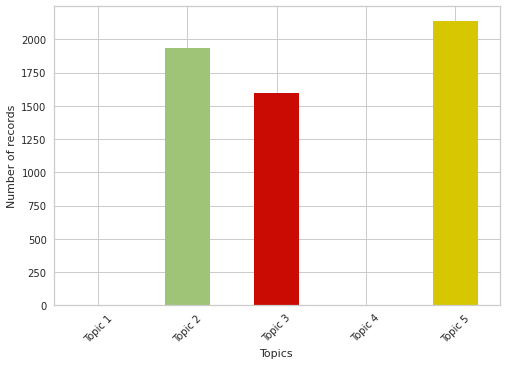

In [54]:
fig, ax = plt.subplots()
df = df_model_en_desc_merged.groupby('winner_topic').size().plot(kind='bar', x='topics', ax=ax)
fig.canvas.draw()

labels = [item.get_text() for item in ax.get_xticklabels()]
labels[0] = 'Topic 1'
labels[1] = 'Topic 2'
labels[2] = 'Topic 3'
labels[3] = 'Topic 4'
labels[4] = 'Topic 5'

ax.set_xticklabels(labels,rotation='45')
ax.set(xlabel='Topics', ylabel='Number of records')

plt.show()

The above plot si a representation of the distribution of the topics as the first option for each docuement.

at this plot we can conclude tha the topic that appear to be more latent in the corpus is the green bar that corresponds to topic 2 and the less prevalent is topic4. Let's now take a more thorough look at the words that are in each topic to have a better understanding of wht might be happening.

### Word Clouds

In [55]:
num_topics = 5
topic_words = []
for i in range(num_topics):
    tt = models[3].get_topic_terms(i,20)
    topic_words.append([id2word[pair[0]] for pair in tt])

In [56]:
models[3].show_topic(0)

[('stay', 0.042063087),
 ('space', 0.021620682),
 ('artist', 0.02129706),
 ('event', 0.02008923),
 ('text', 0.01931351),
 ('sonder', 0.018842515),
 ('check', 0.018579112),
 ('design', 0.015061579),
 ('run', 0.014819877),
 ('equip', 0.013217863)]

In [57]:
df_top_30_n_5 = pd.DataFrame.from_records(topic_words)
df_top_30_n_5 = df_top_30_n_5.T

In [58]:
df_top_30_n_5.rename(columns={0: "Topic 1", 1: "Topic 2",
                              2: "Topic 3", 3: "Topic 4",
                              4: "Topic 5"}, inplace=True)

In [59]:
df_top_30_n_5

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
0,stay,bedroom,walk,check,room
1,space,apartment,train,pm,guest
2,artist,bed,minute,read,home
3,event,full,apartment,show,stay
4,text,floor,restaurant,book,private
5,sonder,room,away,late,share
6,check,kitchen,block,fee,space
7,design,private,neighborhood,early,need
8,run,large,subway,listing,clean
9,equip,queen,close,list,place


In [60]:
top_0 = models[3].show_topic(0, 30)
top_1 = models[3].show_topic(1, 30)
top_2 = models[3].show_topic(2, 30)
top_3 = models[3].show_topic(3, 30)
top_4 = models[3].show_topic(4, 30)

In [61]:
def listtodict(A, di):
    di = dict(A)
    return di 

di_wc_0 = listtodict(top_0,{})
di_wc_1 = listtodict(top_1,{})
di_wc_2 = listtodict(top_2,{})
di_wc_3 = listtodict(top_3,{})
di_wc_4 = listtodict(top_4,{})

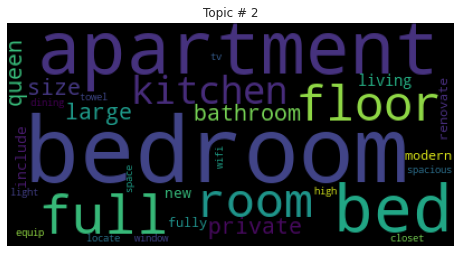

In [62]:
plt.figure()
plt.imshow(WordCloud().fit_words(di_wc_1))
plt.axis("off")
plt.title("Topic # 2")
plt.show()

It seems that Topic 2 has words related to location, for example: walk, train, neighborhood, block, close. This may lead to conclude that the majority of hosts recognize the importance of including such words into their description to attract guests. However, lets see if these words are actually influencing price. For this purpose we will try to understand the importance of each one of these topics' scores in our regression problem. We assume that the larger the impact of the score of each topic in the corpus, the most important to determine its price.

### Creating features X

In [63]:
X = df_model_en_desc_merged.iloc[:, 1:]
X = X.loc[:, X.columns != 'price']
X = X.loc[:, X.columns != 'content']
X = X.loc[:, X.columns != 'content_lang']

### Creating target y

In [64]:
y = df_model_en_desc_merged.price

### Cross validation with multiple regressors

In [65]:
# Create a cross-validation strategy
cv = StratifiedKFold(n_splits=12, random_state=42)

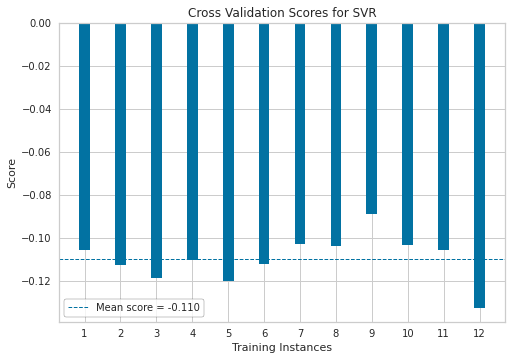

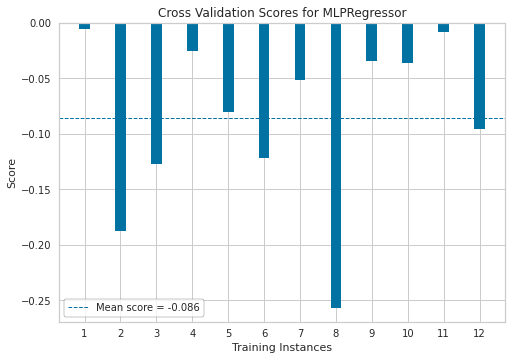

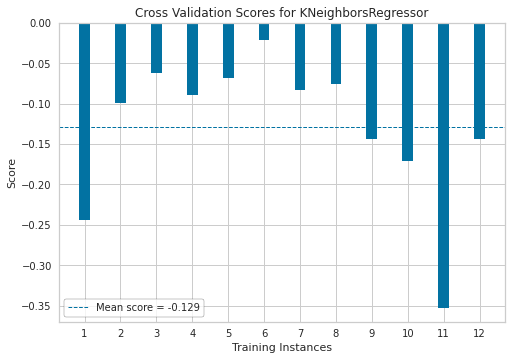

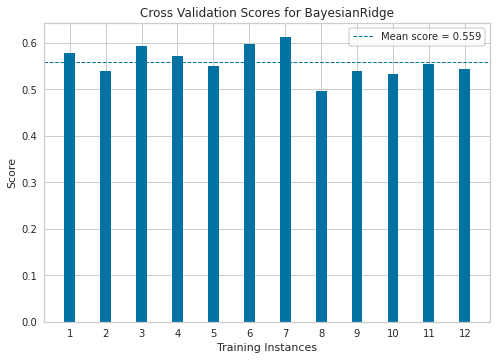

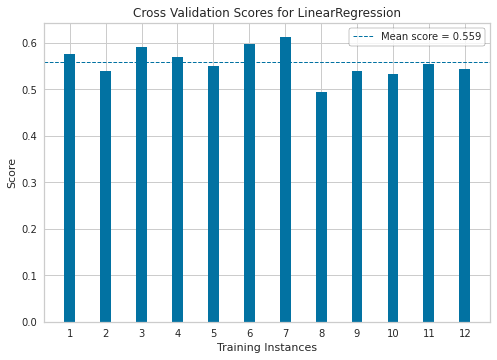

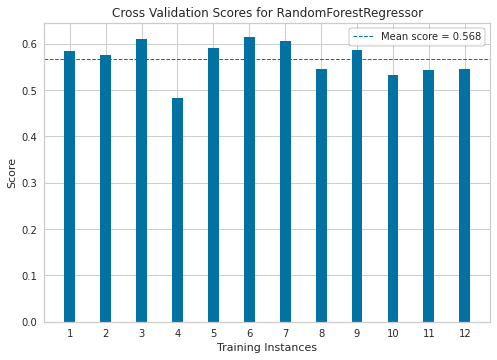

In [66]:
regressors = {
    "support vector machine": SVR(),
    "multilayer perceptron": MLPRegressor(),
    "nearest neighbors": KNeighborsRegressor(),
    "bayesian ridge": BayesianRidge(),
    "linear regression": LinearRegression(),
    "random forest": RandomForestRegressor(),
}

for _, regressor in regressors.items():
    visualizer = CVScores(regressor, cv=cv)
    visualizer.fit(X, y)
    visualizer.show()

## Residuals for multiple regression models

### Split train - test sets

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

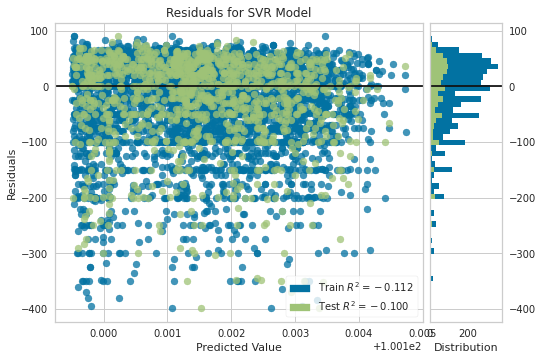

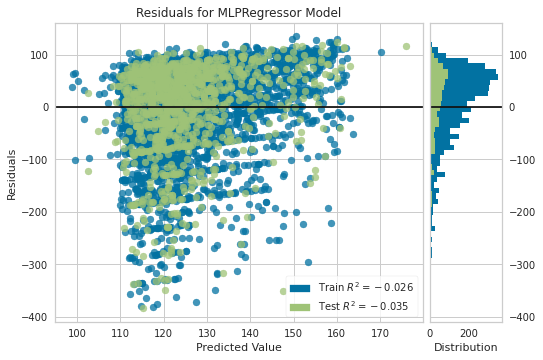

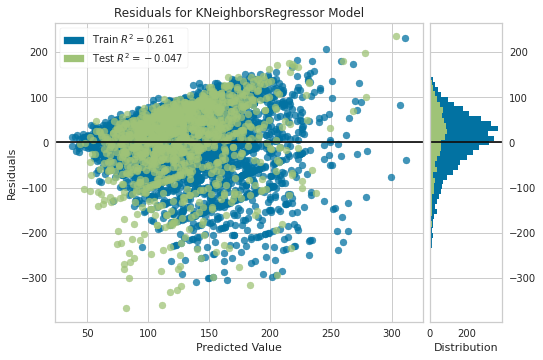

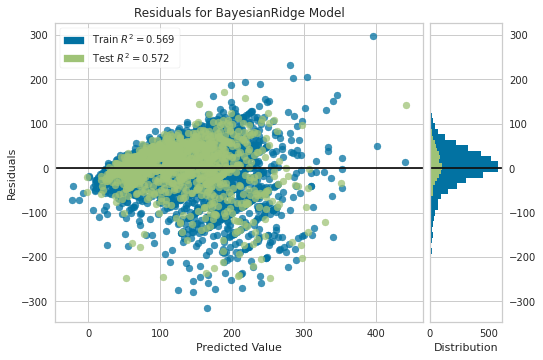

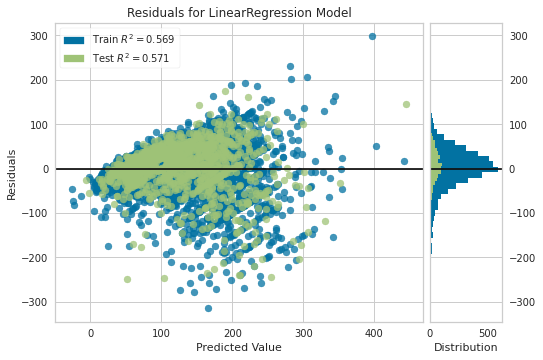

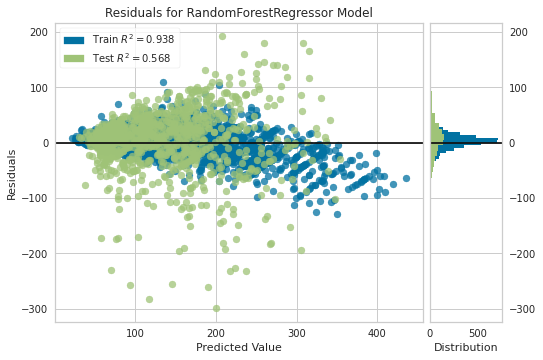

In [68]:
regressors = {
    "support vector machine": SVR(),
    "multilayer perceptron": MLPRegressor(),
    "nearest neighbors": KNeighborsRegressor(),
    "bayesian ridge": BayesianRidge(),
    "linear regression": LinearRegression(),
    "random forest": RandomForestRegressor(),
}

for _, regressor in regressors.items():
    visualizer = ResidualsPlot(regressor)
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    visualizer.show()

After analyzing the average score in cross validations together with the residuals, we can continue to conclude that our baseline model is still the Random Forest Regressor. This excercise was fundamental to see that despite the addition of information about the description, this continues to be true. We will now continue doing some more experimentation.

## Experimenting with the baseline model using the Random Forest Regressor

Random Forest algorithms are ensemble methods of decision trees generated on a random split of a determined data set.The individual decision trees are generated using an attribute selection indicator such as information gain, gain ratio, and Gini index for each attribute. Each tree depends on an independent random sample. In the case of regression, the average of all the tree outputs is considered as the final result. Source: https://www.datacamp.com/community/tutorials/random-forests-classifier-python

In [69]:
# Creating a list of features to use as labels in FeatureImportances
features=list()

for col in df_model_en_desc_merged.columns:
    features.append(col)

# Removing price and id from labels
features.remove('price')
features.remove('content')
features.remove('content_lang')
features.remove('id')

In [70]:
# making sure that the number of columns match with the features
X_train.shape, len(features), y_train.shape

((4540, 53), 53, (4540,))

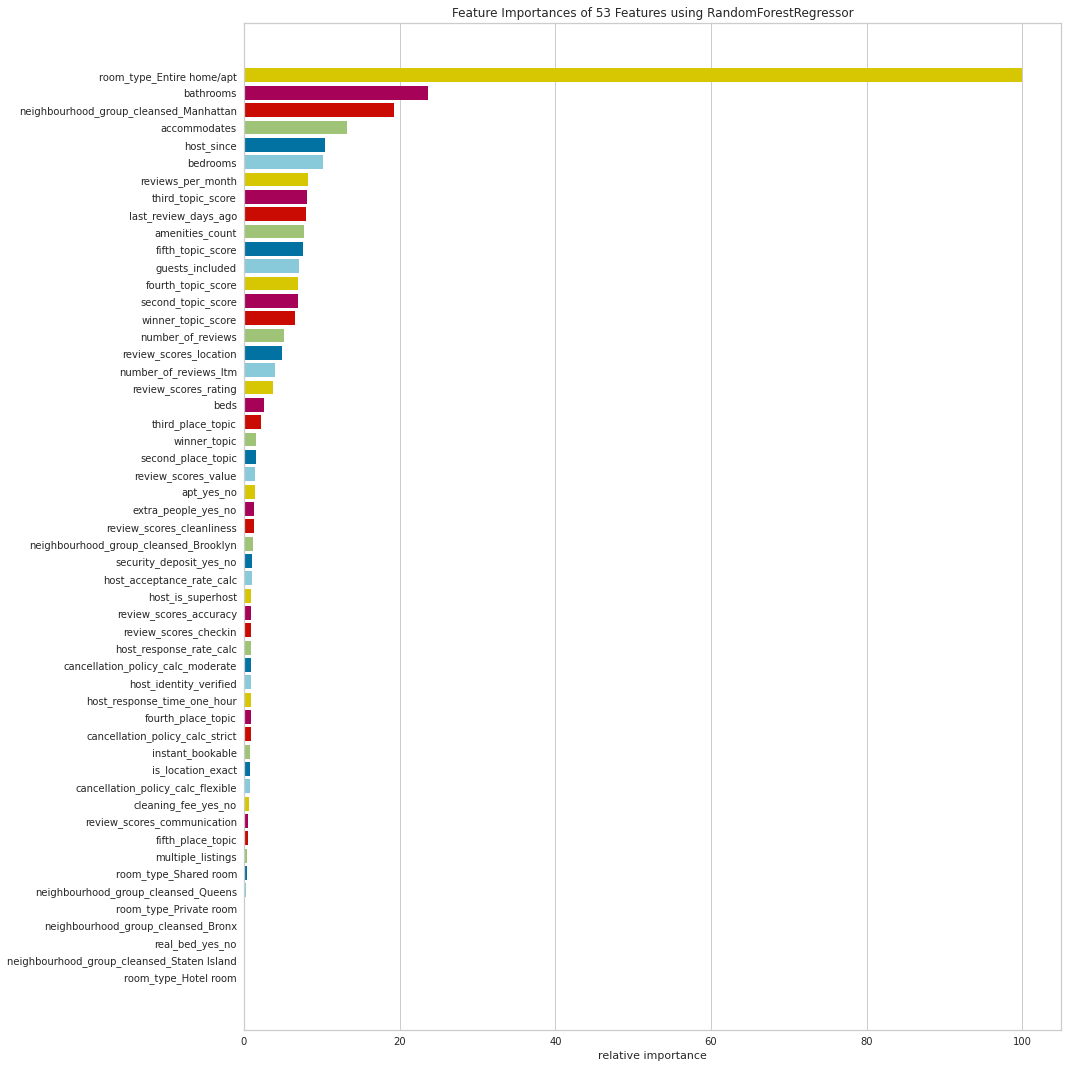

In [71]:
# Most important features
viz = FeatureImportances(regressors['random forest'], labels=features, size=(1080, 1080))
viz.fit(X_train, y_train)
viz.show()

### Creating a random variable 

As we can see in the feature importance graphic above we could conclude that the topics are part of the top features to determine price. To discard the fact that the impact of the scores is due to the fact that the values are numbers from a continuous distribution of numbers, we will create new column with random values from 0 to 1 and run the base regression again. In case this random doesn't appear as part of the next list of most relevant ones, we can be sure to discard this potential challenge

In [72]:
rand_var = list()
for i in range(X.shape[0]):
    rand_var.append(random.uniform(0, 1))

In [73]:
X['random cont variable'] = rand_var

In [74]:
X.shape

(5676, 54)

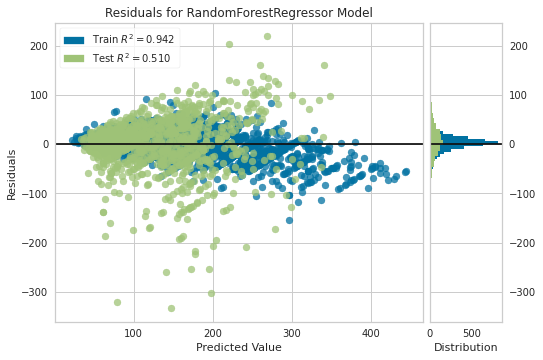

In [75]:
X_w_rand_train, X_w_rand_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Runing Random Forest with random variable
visualizer_2 = ResidualsPlot(RandomForestRegressor())
visualizer_2.fit(X_w_rand_train, y_train)
visualizer_2.score(X_w_rand_test, y_test)
visualizer_2.show()

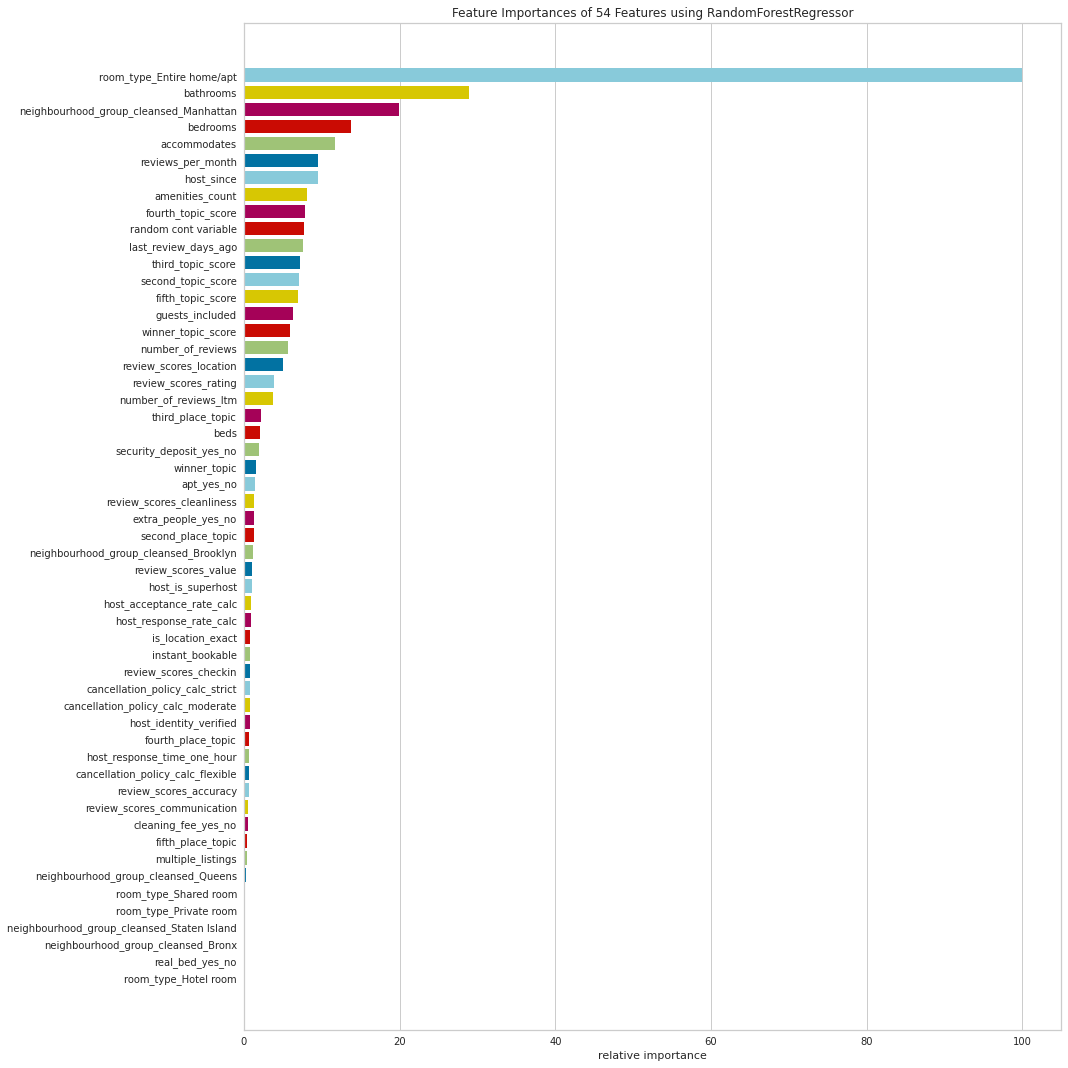

In [76]:
# Most important features
features_w_rand = features.append('random variable')
viz = FeatureImportances(RandomForestRegressor(), labels=features_w_rand, size=(1080, 1080))
viz.fit(X_w_rand_train, y_train)
viz.show()

In [77]:
# X['neighbourhood_group_cleansed_Manhattan'].value_counts()
# X['neighbourhood_group_cleansed_Brooklyn'].value_counts()
# X['host_since'].value_counts()
# X['last_review_days_ago'].value_counts()

In [78]:
# X.columns

### Running the ensemble base model Random Forest removing room_type_Entire home/apt

In [79]:
X_not_prop_type = X.loc[:, X.columns != 'room_type_Entire home/apt']

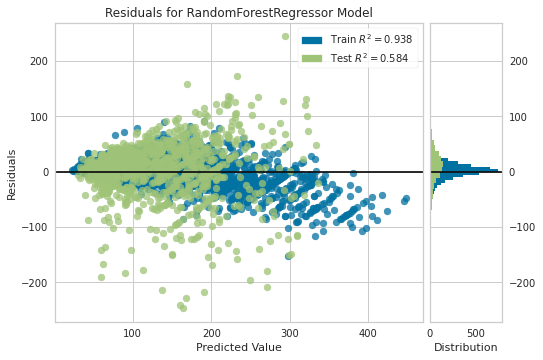

In [80]:
X_not_prop_type_train, X_not_prop_test, y_train, y_test = train_test_split(X_not_prop_type, y, test_size=0.2)

# Runing Random Forest with random variable
visualizer_3 = ResidualsPlot(RandomForestRegressor())
visualizer_3.fit(X_not_prop_type_train, y_train)
visualizer_3.score(X_not_prop_test, y_test)
visualizer_3.show()

In [81]:
# Most important features
features_not_property_typ = features.remove('room_type_Entire home/apt')

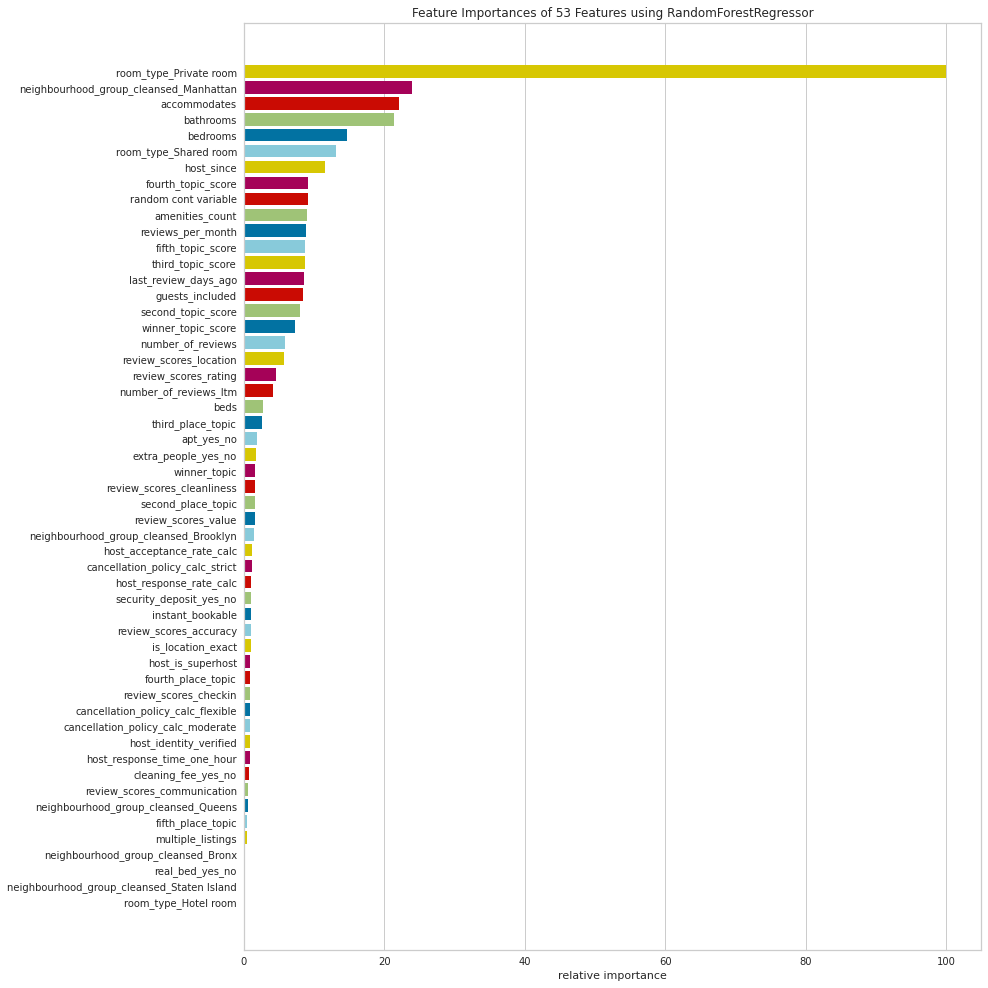

In [82]:
viz_3 = FeatureImportances(RandomForestRegressor(), labels=features_w_rand, size=(1000, 1000))
viz_3.fit(X_not_prop_type_train, y_train)
viz_3.show()

### Determining linearity between room type entire home/apt

In [83]:
df_col = pd.DataFrame()
df_col['room type'] = X['room_type_Entire home/apt']
df_col['price'] = y

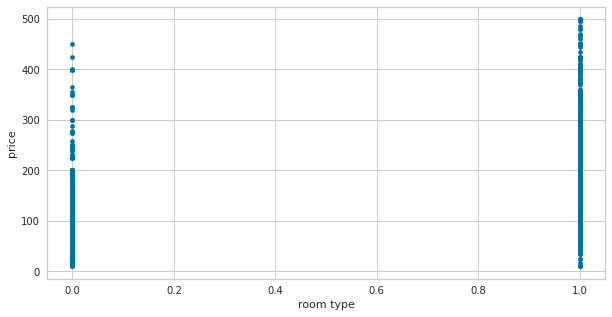

In [84]:
df_col.plot(kind='scatter', x='room type', y='price', figsize=(10,5), grid=True)
# X.plot(kind='scatter', x=X['room_type_Entire home/apt'], y=y, figsize=(10,5), grid=True)

## Applying GradientBoost Regressor

In [88]:
#hyper parameters
regressor = GradientBoostingRegressor()

n_estimators = [100,150,200]
max_depth = [2,3,4,5,6,7]
tuned_params = [{'max_depth': max_depth, 'n_estimators': n_estimators}]
n_folds = 10

grid = GridSearchCV(regressor, tuned_params, cv=10)

grid.fit(X_train, y_train)
print(grid.best_estimator_)

GradientBoostingRegressor(max_depth=2)


In [92]:
#using CV, use best parameter from the grid
regressor = GradientBoostingRegressor(max_depth=6)
regressor = regressor.fit(X_train, y_train) 

#cross validation
scores = cross_val_score(estimator=regressor, X=X_train, y=y_train, cv=10, scoring="neg_mean_squared_error")
rmse_scores = np.sqrt(-scores) 
print(rmse_scores)

[95.82289271 83.14839464 79.07019    79.8815046  87.47585357 80.47324266
 82.67304989 78.7684141  86.21394462 90.57447472]


In [96]:
pred_train= regressor.predict(X_train)
print(rmse_scores.mean())
print(r2_score(y_train, pred_train))

84.41019614959626
0.5114988855613128


In [97]:
pred_test= regressor.predict(X_test)
print(np.sqrt(mean_squared_error(y_test,pred_test))) 
print(r2_score(y_test, pred_test))

81.43485089069125
-0.08401336611725796


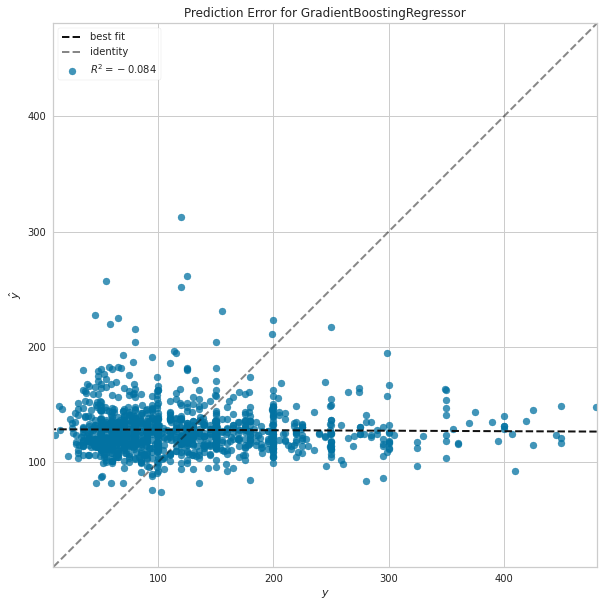

In [101]:
#Instantiate the linear model and visualizer
visualizer = PredictionError(regressor, size=(1080, 720))

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Draw the data

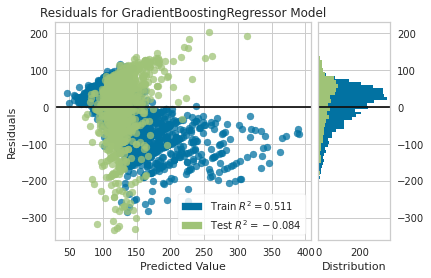

In [102]:
#chart
oz = ResidualsPlot(regressor)

oz.fit(X_train, y_train)
oz.score(X_test, y_test)
_ = oz.show()

## Feature Importance

In [108]:
# Creating a list of features to use as labels in FeatureImportances
features=list()

for col in df_model_en_desc_merged.columns:
    features.append(col)

# Removing price and id from labels
features.remove('price')
features.remove('content')
features.remove('content_lang')
features.remove('id')

In [110]:
features

['host_since',
 'host_is_superhost',
 'host_identity_verified',
 'is_location_exact',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'guests_included',
 'number_of_reviews',
 'number_of_reviews_ltm',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'instant_bookable',
 'reviews_per_month',
 'cleaning_fee_yes_no',
 'security_deposit_yes_no',
 'extra_people_yes_no',
 'last_review_days_ago',
 'amenities_count',
 'host_response_time_one_hour',
 'host_response_rate_calc',
 'host_acceptance_rate_calc',
 'apt_yes_no',
 'real_bed_yes_no',
 'multiple_listings',
 'neighbourhood_group_cleansed_Bronx',
 'neighbourhood_group_cleansed_Brooklyn',
 'neighbourhood_group_cleansed_Manhattan',
 'neighbourhood_group_cleansed_Queens',
 'neighbourhood_group_cleansed_Staten Island',
 'room_type_Entire home/apt',
 'room_type_Hotel room',
 'room_type_Private room'

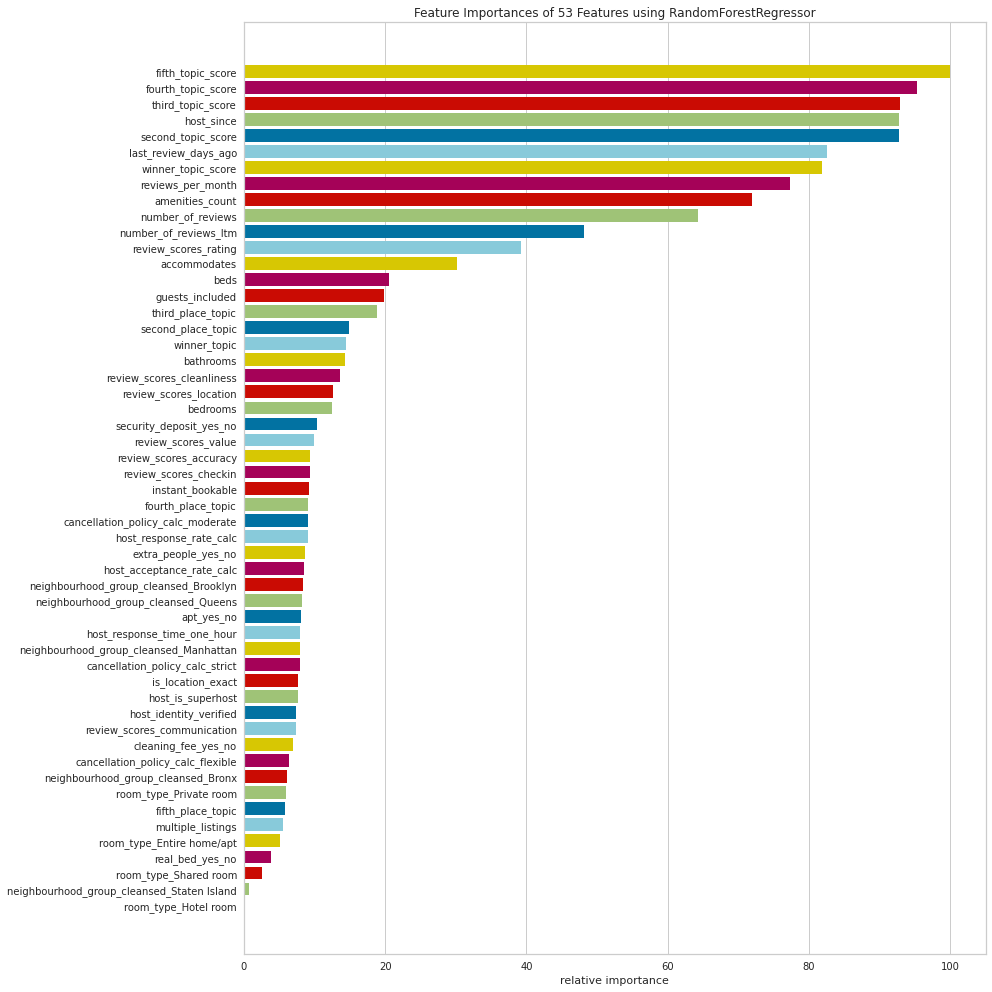

In [111]:
# Most important features
viz_4 = FeatureImportances(RandomForestRegressor(), labels=features, size=(1000, 1000))
viz_4.fit(X_train, y_train)
viz_4.show()